In [ ]:
!pip install -q pyomo

In [ ]:
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus, TerminationCondition

## Pricing w/o Fairness

In [ ]:
from pyomo.environ import *

def pricing(Lambda1, Lambda2, b1, b2, d1=1, d2=1, c1=1, c2=1, relocation = True, Debug = True):

  # create a model
  model = ConcreteModel()

  # declare decision variables
  model.l1 = Var(domain=NonNegativeReals)
  model.l2 = Var(domain=NonNegativeReals)
  model.pi_10 = Var(domain=NonNegativeReals)
  model.pi_01 = Var(domain=NonNegativeReals)
  if relocation:
    model.r1 = Var(domain=NonNegativeReals)
    model.r2 = Var(domain=NonNegativeReals)

  # price
  model.p1 = b1 * (1-model.l1/Lambda1)
  model.p2 = b2 * (1-model.l2/Lambda2)

  # Constraints
  model.c1 = Constraint(expr = model.l1 <= Lambda1)
  model.c2 = Constraint(expr = model.l2 <= Lambda2)
  if relocation:
    model.c3 = Constraint(expr = (model.l1) * model.pi_10 + model.r1 == (model.l2) * model.pi_01 + model.r2)
    model.c4 = Constraint(expr = model.pi_10 + model.pi_01 == 1)
    model.c5 = Constraint(expr = model.r1 >= 0)
    model.c6 = Constraint(expr = model.r2 >= 0)
  else:
    model.c3 = Constraint(expr = model.l1 * model.pi_10 == model.l2 * model.pi_01)
    model.c4 = Constraint(expr = model.pi_10 + model.pi_01 == 1)

  # Revenue
  if relocation:
    model.revenue = Objective(expr = (model.l1 * model.p1) * model.pi_10 - c1 * model.r1 + (model.l2 * model.p2)* model.pi_01 - c2 * model.r2, sense=maximize)
  else:
    model.revenue = Objective(expr = model.l1 * model.pi_10 * model.p1 + model.l2 * model.pi_01 * model.p2, sense=maximize)

  SolverFactory('couenne').solve(model)#.write()

  # display solution
  if Debug:
    print('\nRevenue = ', model.revenue())

    print('Optimal Variables')
    print('(p1, p2) = (%.10f, %.10f)' %(model.p1(), model.p2()))
    print('(l1, l2) = (%.10f, %.10f)' %(model.l1(), model.l2()))
    print('(pi_10, pi_01) = (%.10f, %.10f)' %(model.pi_10(), model.pi_01()))
    if relocation:
      print('(psi1, psi2) = (%.10f, %.10f)' %(model.r1(), model.r2()))

  # if model.r1() + model.r2() > 1e-3:
  #   if model.r1() > model.r2():
  #     if model.l1() < 1e-3:
  #       p1 = model.p2()
  #   else:
  #     if model.l2() < 1e-3:
  #       p2 = model.p1()

  M1 = model.p1()/d1 - model.p2()/d2
  M2 = model.l1()/Lambda1 * model.pi_10() - model.l2()/Lambda2 * model.pi_01()

  return {'Price': abs(M1), 'Access': abs(M2)}

In [ ]:
def analytical_solution(Lambda1, Lambda2, b1, b2):
  beta1, beta2 = b1/Lambda1, b2/Lambda2
  if np.sqrt(b2/b1) - np.sqrt(b1/b2) >= 2*np.sqrt(Lambda1/Lambda2):
    p1, p2 = 0, b2 + beta2 * (Lambda1 - np.sqrt(Lambda1 * (1+Lambda2)))
    l2 = -Lambda1 + np.sqrt(Lambda1 * (1+Lambda2))
  elif np.sqrt(b1/b2) - np.sqrt(b2/b1) >= 2*np.sqrt(Lambda2/Lambda1):
    p1, p2 = b1 + beta1 * (Lambda2 - np.sqrt(Lambda2 * (1+Lambda1))), 0
  else:
    p1, p2 =  b1 - np.sqrt(beta1)/2 * (b1+b2)/(np.sqrt(beta1)+np.sqrt(beta2)), b2 - np.sqrt(beta2)/2 * (b1+b2)/(np.sqrt(beta1)+np.sqrt(beta2))
  print('(p1, p2) = (%.3f, %.3f)' %(p1, p2))

In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 4
M_star = pricing(Lambda1, Lambda2, b1, b2, relocation = False)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2)


Revenue =  1.5278704771569336
Optimal Variables
(p1, p2) = (0.0000000000, 2.7646713827)
(l1, l2) = (1.0000000000, 1.2353286173)
(pi_10, pi_01) = (0.5526365286, 0.4473634714)
(p1, p2) = (0.000, 2.764)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 4
c1, c2 = 1, 1
M_star = pricing(Lambda1, Lambda2, b1, b2, c1=c1, c2=c2, relocation = True)


Revenue =  2.2499999899966916
Optimal Variables
(p1, p2) = (0.9995001314, 2.5000000003)
(l1, l2) = (0.0004998686, 1.4999999997)
(pi_10, pi_01) = (0.0000000000, 1.0000000000)
(psi1, psi2) = (1.5000000047, 0.0000000050)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 2, 1
b1, b2 = 1, 5
M_star = pricing(Lambda1, Lambda2, b1, b2, c1=1, c2=1)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2)


Revenue =  1.0389937623648868
Optimal Variables
(p1, p2) = (0.2788430033, 2.7267400999)
(l1, l2) = (1.4423139934, 0.4546519800)
(pi_10, pi_01) = (0.2396690079, 0.7603309921)
(psi1, psi2) = (0.0000000000, -0.0000080271)
(p1, p2) = (0.279, 2.721)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 2, 1
b1, b2 = 1, 5
M_star = pricing(Lambda1, Lambda2, b1, b2, c1=0.1, c2=0.1)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2)


Revenue =  1.2005000009998188
Optimal Variables
(p1, p2) = (0.9995454053, 2.5500000000)
(l1, l2) = (0.0009091894, 0.4900000000)
(pi_10, pi_01) = (0.0000000000, 1.0000000000)
(psi1, psi2) = (0.4899999950, -0.0000000050)
(p1, p2) = (0.279, 2.721)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 2
M_star = pricing(Lambda1, Lambda2, b1, b2, c1=0.1, c2=0.1)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2)


Revenue =  1.8049999972499922
Optimal Variables
(p1, p2) = (0.5318587761, 1.0500000000)
(l1, l2) = (0.4681412239, 1.9000000000)
(pi_10, pi_01) = (0.0000000000, 1.0000000000)
(psi1, psi2) = (1.9000000138, 0.0000000138)
(p1, p2) = (0.121, 1.379)


In [ ]:
# Check analytical solution
Lambda1, Lambda2 = 5, 1
b1, b2 = 5, 6
M_star = pricing(Lambda1, Lambda2, b1, b2, c1=0.1, c2=0.1)
print("="*30)
analytical_solution(Lambda1, Lambda2, b1, b2)


Revenue =  6.0025
Optimal Variables
(p1, p2) = (2.5499999994, 2.9937193702)
(l1, l2) = (2.4500000006, 0.5010467716)
(pi_10, pi_01) = (1.0000000000, 0.0000000000)
(psi1, psi2) = (0.0000000000, 2.4500000006)
(p1, p2) = (3.406, 2.094)


## Pricing w/ Fair Constraints

In [ ]:
from pyomo.environ import *

def fair_pricing(Lambda1, Lambda2, b1, b2, M_star, alpha, d1=1, d2=1, c1=1, c2=1, criteria = 'Price', relocation = True, Debug = True, regular=True):

  # create a model
  model = ConcreteModel()

  # declare decision variables
  model.l1 = Var(domain=NonNegativeReals)
  model.l2 = Var(domain=NonNegativeReals)
  model.pi_10 = Var(domain=NonNegativeReals)
  model.pi_01 = Var(domain=NonNegativeReals)
  if relocation:
    model.r1 = Var(domain=NonNegativeReals)
    model.r2 = Var(domain=NonNegativeReals)

  # price
  model.p1 = b1 * (1-model.l1/Lambda1)
  model.p2 = b2 * (1-model.l2/Lambda2)

  # Constraints
  model.c1 = Constraint(expr = model.l1 <= Lambda1)
  model.c2 = Constraint(expr = model.l2 <= Lambda2)
  if relocation:
    model.c3 = Constraint(expr = model.l1 * model.pi_10 + model.r1 == model.l2 * model.pi_01 + model.r2)
    model.c4 = Constraint(expr = model.pi_10 + model.pi_01 == 1)
    model.c5 = Constraint(expr = model.r1 <= model.pi_01 * model.l2)
    model.c6 = Constraint(expr = model.r2 <= model.pi_10 * model.l1)
  else:
    model.c3 = Constraint(expr = model.l1 * model.pi_10 == model.l2 * model.pi_01)
    model.c4 = Constraint(expr = model.pi_10 + model.pi_01 == 1)

  # Revenue
  if relocation:
    model.revenue = Objective(expr = model.l1 * model.pi_10 * model.p1 + model.l2 * model.pi_01 * model.p2 - c1 * model.r1 - c2 * model.r2, sense=maximize)
  else:
    model.revenue = Objective(expr = model.l1 * model.pi_10 * model.p1 + model.l2 * model.pi_01 * model.p2, sense=maximize)

  M_star = M_star[criteria]
  if criteria == 'Price':
    if alpha != 1:
      model.c7 = Constraint(expr = model.p1/d1 - model.p2/d2 <= (1-alpha) * M_star)
      model.c8 = Constraint(expr = model.p2/d2 - model.p1/d1 <= (1-alpha) * M_star)
    else:
      model.c7 = Constraint(expr = model.p1/d1 == model.p2/d2)
  elif criteria == 'Access':
    model.c7 = Constraint(expr = model.l1/Lambda1 * model.pi_10 - model.l2/Lambda2 * model.pi_01 <= (1-alpha) * M_star)
    model.c8 = Constraint(expr = model.l2/Lambda2 * model.pi_01 - model.l1/Lambda1 * model.pi_10 <= (1-alpha) * M_star)
  else:
    print("Warning: no criteria matached")

  SolverFactory('couenne').solve(model)#.write()

  # display solution
  if Debug:
    print('\nRevenue = ', model.revenue())

    print('Optimal Variables')
    print('p1 =', model.p1())
    print('p2 =', model.p2())
    print('l1 = ', model.l1())
    print('l2 = ', model.l2())
    print('pi_10 =', model.pi_10())
    print('pi_01 =', model.pi_01())

  if relocation:
    r1, r2 = model.r1(), model.r2()
  else:
    r1, r2 = 0, 0

  S1 = (b1-model.p1())/(2*Lambda1) * model.l1() * model.pi_10()
  S2 = (b2-model.p2())/(2*Lambda2) * model.l2() * model.pi_01()
  total_surplus = Lambda1 * S1 + Lambda2 * S2

  if regular:
    return [model.p1(), model.p2()], model.revenue(), [S1, S2], total_surplus, [model.l1()/Lambda1 * model.pi_10(), model.l2()/Lambda2 * model.pi_01()], [model.pi_10(), model.pi_01()], [r1, r2]
  else:
    p2 = b1 + M_star
    p1 = p2 - (1-alpha) * M_star
    l1 = 0
    l2 = Lambda2 * (1-p2/b2)
    r1 = 0
    r2 = l2
    pi_10 = 0
    pi_01 = 1

    revenue = l1 * pi_10 * p1 + l2 * pi_01 * p2 - c1 * r1 - c2 * r2
    S1 = (b1-p1)/(2*Lambda1) * l1 * pi_10
    S2 = (b2-p2)/(2*Lambda2) * l2 * pi_01
    total_surplus = Lambda1 * S1 + Lambda2 * S2
    return [p1,p2], revenue, [S1, S2], total_surplus, [l1/Lambda1 * pi_10,l2/Lambda2 *pi_01], [pi_10, pi_01], [r1, r2]


## Plots

In [ ]:
def simulator(Lambda1, Lambda2, b1, b2, d1=1, d2=1, c1=1, c2=1, criteria_list=['Price', 'Access'], n_iter=10, relocation=True, Debug=False, regular=True):
  M_star = pricing(Lambda1, Lambda2, b1, b2, d1, d2, c1, c2, relocation, Debug)

  price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, r_all = {}, {}, {}, {}, {}, {}, {}
  for criteria in criteria_list:
    price_list, revenue_list, surplus_list, total_surplus_list, access_list, r_list = [], [], [], [], [], []
    pi_list = [[] for i in range(2)]
    for a in range(n_iter+1):
      price, revenue, surplus, total_surplus, access, steady_state, r = fair_pricing(Lambda1, Lambda2, b1, b2, M_star, a/n_iter, d1, d2, c1, c2, criteria = criteria, relocation=relocation, Debug=Debug, regular=regular)
      price_list.append(price)
      revenue_list.append(revenue)
      surplus_list.append(surplus)
      total_surplus_list.append(total_surplus)
      access_list.append(access)
      r_list.append(r)
      for j in range(len(steady_state)):
        pi_list[j].append(steady_state[j])

    price_all[criteria] = price_list
    revenue_all[criteria] = revenue_list
    surplus_all[criteria] = surplus_list
    total_surplus_all[criteria] = total_surplus_list
    access_all[criteria] = access_list
    pi_all[criteria] = pi_list
    r_all[criteria] = r_list

  return price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, r_all

In [ ]:
from google.colab import files
def subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all, r_all, d=[1,1], _filename = 'figure'):
  price_list, revenue_list, surplus_list, total_surplus_list, access_list, pi_list, r_list\
   = price_all[criteria], revenue_all[criteria], surplus_all[criteria], total_surplus_all[criteria], access_all[criteria], pi_all[criteria], r_all[criteria]

  fig, axs = plt.subplots(1, 5)
  fig.set_figheight(3.5)
  fig.set_figwidth(30)

  size = 28
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)]

  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0, linestyle='--')
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0, linestyle=':')
  axs[0].set_xlim([0, 1])
  axs[0].grid()

  axs[1].plot(iter_list, [p[0]/d[0] for p in price_list], label=r'$p_1$',linewidth=3.0)
  axs[1].plot(iter_list, [p[1]/d[1] for p in price_list], label=r'$p_2$',linewidth=3.0, linestyle='--')
  axs[1].set_xlim([0, 1])
  axs[1].grid()

  axs[2].plot(iter_list, [s[0] for s in access_list], label=r'$A_1$',linewidth=3.0)#\Pi_1q_1
  axs[2].plot(iter_list, [s[1] for s in access_list], label=r'$A_2$',linewidth=3.0, linestyle='--')
  axs[2].set_xlim([0, 1])
  axs[2].grid()

  axs[3].plot(iter_list, [s[0] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0)
  axs[3].plot(iter_list, [s[1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0, linestyle='--')
  axs[3].set_xlim([0, 1])
  axs[3].grid()

  axs[4].plot(iter_list, [r[0] for r in r_list], label=r'$\psi_1\Pi_1$',linewidth=3.0)
  axs[4].plot(iter_list, [r[1] for r in r_list], label=r'$\psi_2\Pi_2$',linewidth=3.0, linestyle='--')
  axs[4].set_xlim([0, 1])
  axs[4].grid()

  for i in range(5):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
                  fancybox=True, shadow=True, ncol=3, prop={"size":18})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28)

  plt.savefig(_filename + '.pdf', format='pdf', bbox_inches='tight')
  files.download(_filename + '.pdf')
  plt.show()

  fig, axs = plt.subplots(1, 2)
  fig.set_figheight(3.5)
  fig.set_figwidth(12)

  axs[0].plot(iter_list, pi_list[0], label=r'$\pi_1$',linewidth=3.0)
  axs[0].plot(iter_list, pi_list[1], label=r'$\pi_2$',linewidth=3.0)
  axs[0].set_xlim([0, 1])
  axs[0].grid()

  axs[1].plot(iter_list, [r[0] for r in r_list], label=r'$z_1$',linewidth=3.0)
  axs[1].plot(iter_list, [r[1] for r in r_list], label=r'$z_2$',linewidth=3.0)
  axs[1].set_xlim([0, 1])
  axs[1].grid()


  for i in range(2):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
                  fancybox=True, shadow=True, ncol=3, prop={"size":18})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(16)


  plt.show()

## Experiments

In [ ]:
criteria_list = ['Price']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

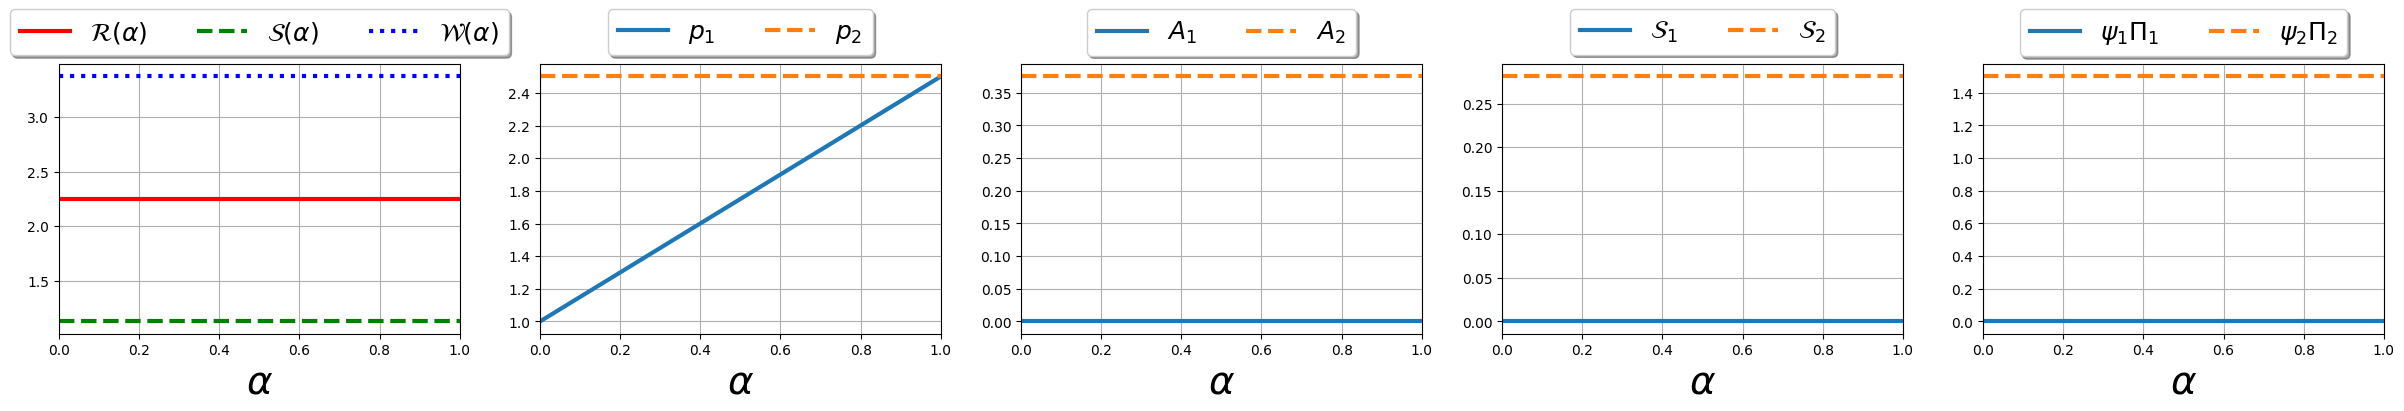

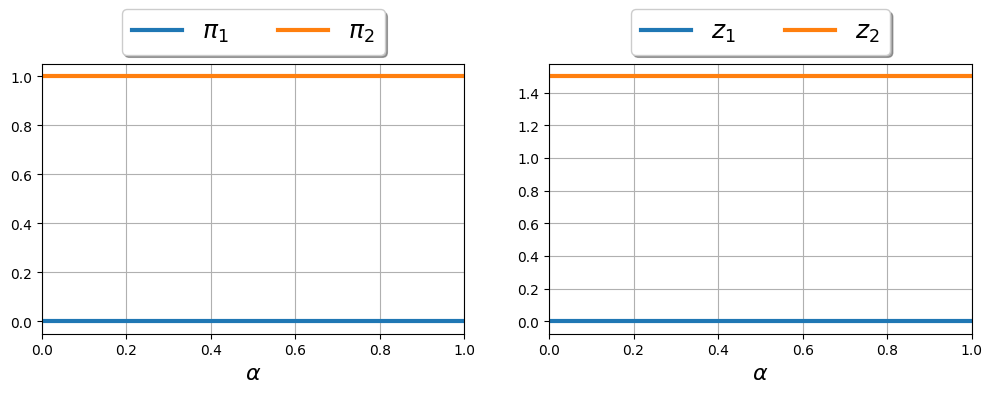

In [ ]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 4
c1, c2 = 1, 1
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all, r_all = simulator(Lambda1, Lambda2, b1, b2, c1=c1, c2=c2, criteria_list=criteria_list, relocation=True, Debug=False, regular=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all, r_all, _filename = 'price_reposition')

### Access Fairness

In [ ]:
criteria_list = ['Access']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

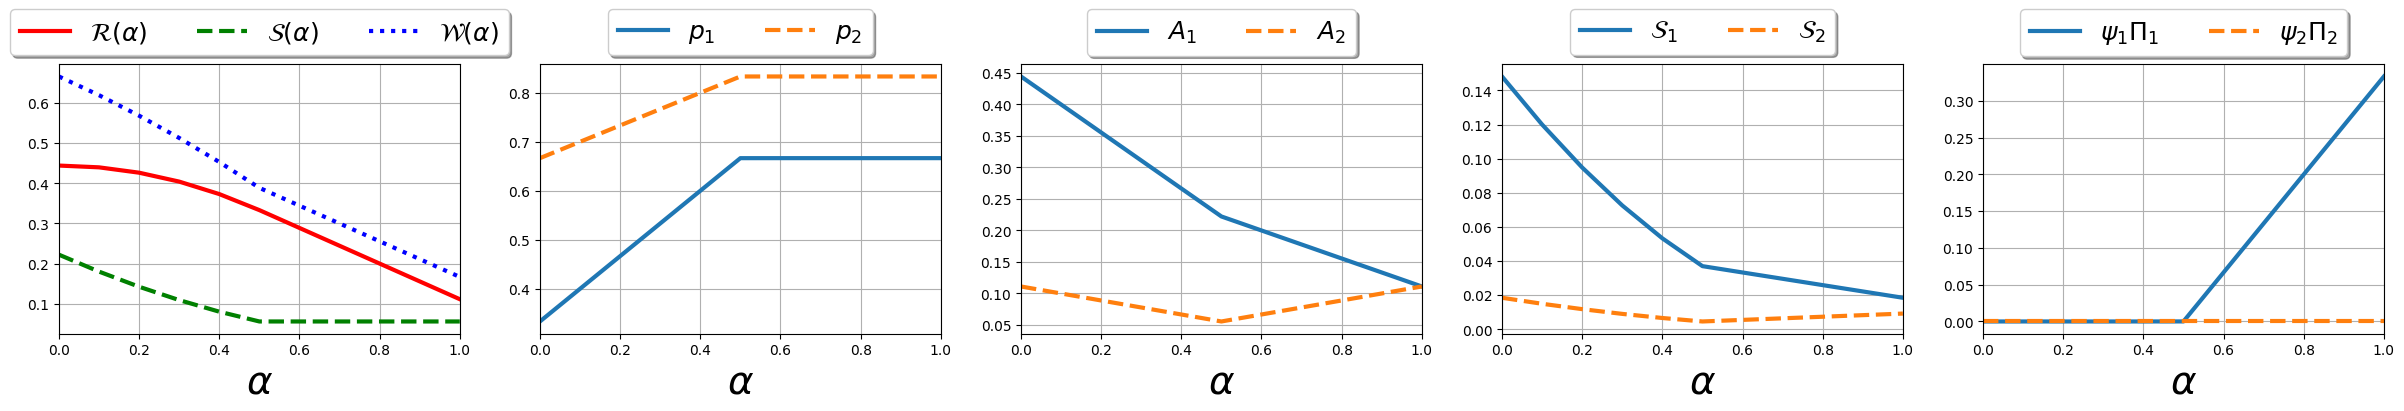

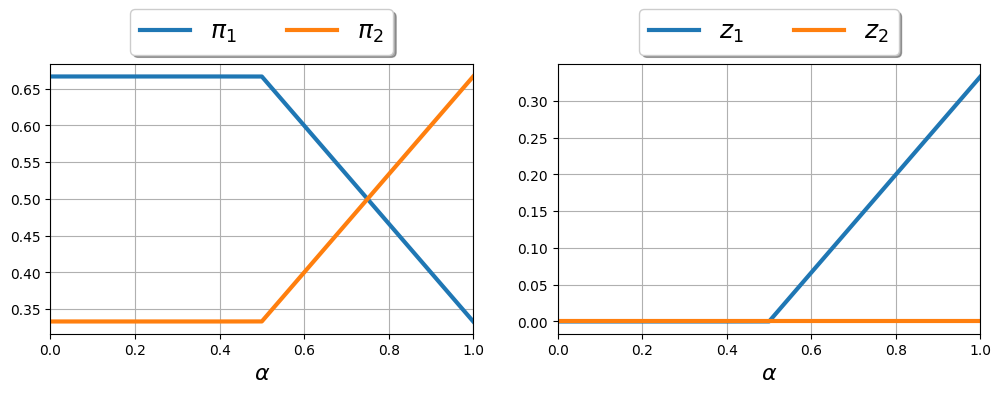

In [ ]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 1
c1, c2 = 1, 1
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all, r_all = simulator(Lambda1, Lambda2, b1, b2, c1=c1, c2=c2, criteria_list=criteria_list, relocation=True, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all, r_all, _filename='access_reposition_1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

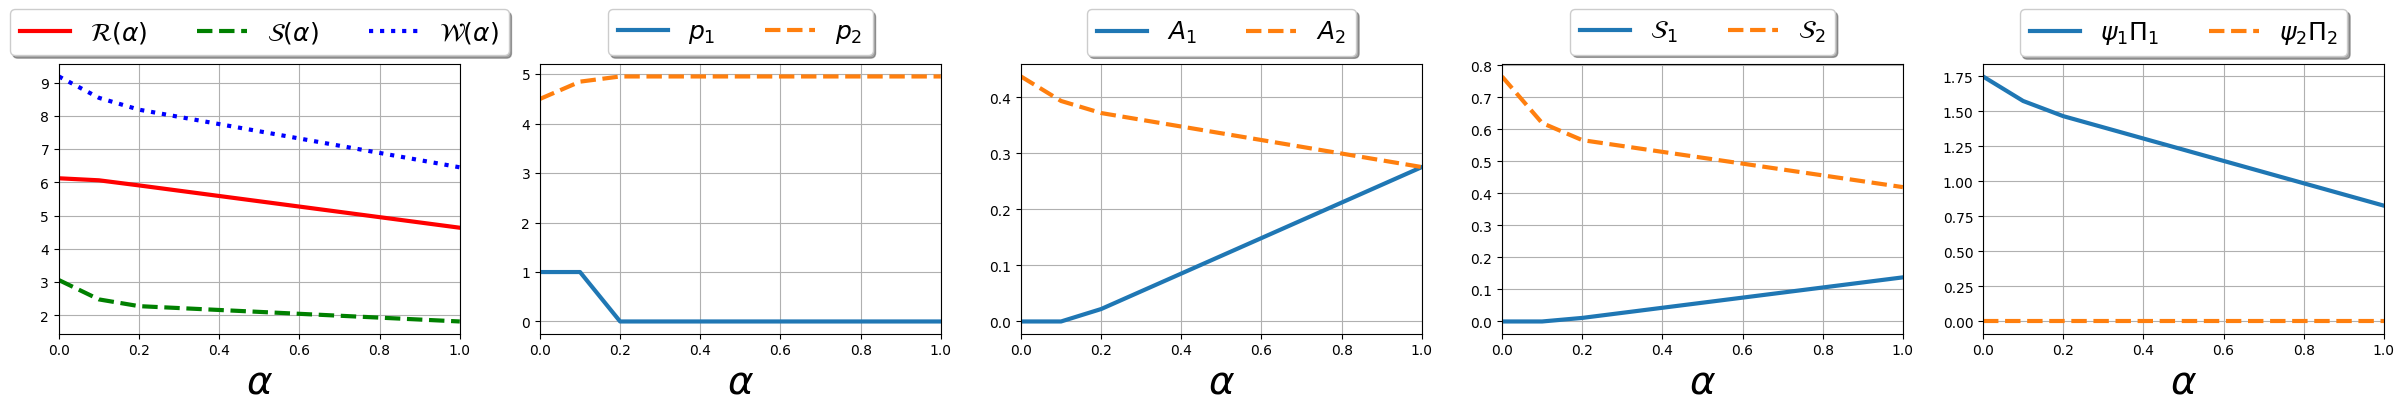

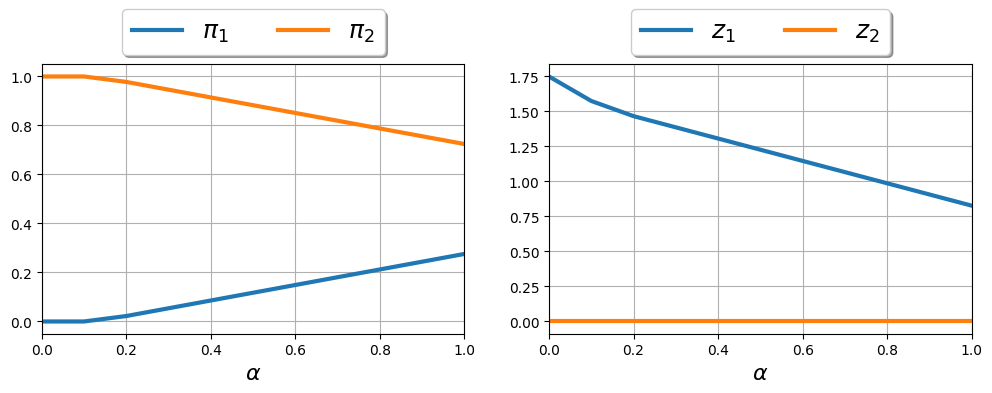

In [ ]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 8
c1, c2 = 1, 1
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all, r_all = simulator(Lambda1, Lambda2, b1, b2, c1=c1, c2=c2, criteria_list=criteria_list, relocation=True, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all, r_all, _filename='access_reposition_2')